In [1]:
%%javascript
// Disable the scrollbar in output cells
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Analysis of survey evaluations

This Jupyter notebook examines the evaluations recorded in `data/evaluations.csv` and `data_nn/evaluations_nn.csv`.

The analysis has been modified from the origianl version, to make the functions more general. 

The analysis is additionally duplicated for the original AAAI selection, and repeated for a
selection from the AI Reproducibility master's thesis research from 2018. This selection is grouped by year, 
rather than by conference, as the selection was not made with respect to conferences, but with respect to years.

## The data
We start by loading the CSV file into a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) and print some information on the size and structure of the dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn', hides SettingWithCopyWarning

def print_summary(file, groupby_name):
    conversion_dict = {'research_type': lambda x: int(x == 'E')}
    evaluation_data = pd.read_csv(file,
                                  sep=',',
                                  header=0,
                                  index_col=0,
                                  converters=conversion_dict)

    print('Samples per {groupby_name}\n{data}'.format(groupby_name=groupby_name,
                                                      data=evaluation_data.groupby(groupby_name).size()
                                                     ),
          end='\n')

    column_headers = evaluation_data.columns.values
    print('\nColumn headers: {}'.format(column_headers))

    return evaluation_data

print("AAAI")
evaluation_data_aaai = print_summary('data/evaluations.csv', 'conference')

print("\nAIReproduction2018:")
evaluation_data_air2018 = print_summary('data_nn/evaluations_nn.csv', 'year')
# The papers are listed alphabetically rather than by index in the .csv-file
# The order of the indexing is rather arbitrary, according to the order the papers were logged
evaluation_data_air2018.sort_index(axis=0, inplace=True)


AAAI
Samples per conference
conference
AAAI 14     100
AAAI 16     100
IJCAI 13    100
IJCAI 16    100
dtype: int64

Column headers: ['title' 'research_type' 'result_outcome' 'affiliation'
 'problem_description' 'goal/objective' 'research_method'
 'research_question' 'hypothesis' 'prediction' 'contribution' 'pseudocode'
 'open_source_code' 'open_experiment_code' 'train' 'validation' 'test'
 'results' 'hardware_specification' 'software_dependencies'
 'third_party_citation' 'experiment_setup' 'evaluation_criteria' 'authors'
 'link' 'comments' 'conference']

AIReproduction2018:
Samples per year
year
2012    10
2014    10
2016    10
dtype: int64

Column headers: ['year' 'title' 'research_type' 'result_outcome' 'affiliation'
 'problem_description' 'goal/objective' 'research_method'
 'research_question' 'hypothesis' 'prediction' 'contribution' 'pseudocode'
 'open_source_code' 'open_experiment_code' 'train' 'validation' 'test'
 'results' 'hardware_specification' 'software_dependencies'
 'thir

The dataset has 400 samples with 27 columns. Some of these columns are not necessary for further analysis: *title*, *authors*, *link*, *comments*. Dropping these leaves us with a numerical index for each paper, the conference it was published to, and survey related data. The lambda function above converts the *research_type* data from E (experimental) and T (theoretical) to 1 and 0 respectively, making it easier to work with in pandas.

In [3]:
def drop_columns(evaluation_data):
    evaluation_data.drop(['title', 'authors', 'link', 'comments'], axis=1, inplace=True)
    #column_headers = evaluation_data.columns.values
    display(evaluation_data.head(2))

print("AAAI: ")
drop_columns(evaluation_data_aaai)
print("\nAI Reproducibility 2018: ")
drop_columns(evaluation_data_air2018)

AAAI: 


,research_type,result_outcome,affiliation,problem_description,goal/objective,research_method,research_question,hypothesis,prediction,contribution,...,train,validation,test,results,hardware_specification,software_dependencies,third_party_citation,experiment_setup,evaluation_criteria,conference
index,,,,,,,,,,,,,,,,,,,,,
1,1,1,0,1,0,0,0,0,0,1,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,IJCAI 16
2,0,1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IJCAI 16



AI Reproducibility 2018: 


,year,research_type,result_outcome,affiliation,problem_description,goal/objective,research_method,research_question,hypothesis,prediction,...,train,validation,test,results,hardware_specification,software_dependencies,third_party_citation,experiment_setup,evaluation_criteria,conference
index,,,,,,,,,,,,,,,,,,,,,
1,2012,1,1,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0,1,0,1,1,NaN,IEEE Transactions on Pattern Analysis and Mach...
2,2012,1,1,0,1,0,0,0,0,0,...,NaN,NaN,NaN,1,1,0,1,1,NaN,Information Sciences


The above two rows exemplify an experimental (top row) and a theoretical (bottom row) paper. Values with a NaN value appear for theoretical papers for all columns that are specific to experimental papers. For the *affiliation* column, 0 represents academia, 1 represents collaboration and 2 represents industry authors. The remaining columns are boolean, 1 if documented and 0 if not. Note that some experimental papers have no value (NaN) for training and/or validation data if a train/validation/test split is not applicable.

## Miscellaneous statistics

In [4]:
def print_misc_stats(evaluation_data, groupby_name):
    print('Samples per affiliation\n{}'.format(evaluation_data.groupby('affiliation').size()
                                              ), 
          end='\n\n')
    print('Affiliation by {}\n{}'.format('groupby_name',
                                         evaluation_data.groupby([groupby_name, 'affiliation']).size()
                                        ), 
          end='\n\n')

    print('Samples per research type\n{}'.format(evaluation_data.groupby('research_type').size()), end='\n\n')
    print('Research type by {}\n{}'.format('groupby_name',
                                           evaluation_data.groupby([groupby_name, 'research_type']).size()
                                          ), 
          end='\n\n')

    print('Samples per research outcome\n{}'.format(evaluation_data.groupby('result_outcome').size()), end='\n\n')
    print('Research outcome by {}\n{}'.format('groupby_name',
                                              evaluation_data.groupby([groupby_name, 'result_outcome']).size()
                                             ), 
          end='\n\n')

    print('Samples with contribution\n{}'.format(evaluation_data.groupby('contribution').size()), end='\n\n')
    print('Contribution by {}\n{}'.format('groupby_name',
                                          evaluation_data.groupby([groupby_name, 'contribution']).size()
                                         ), 
          end='\n\n')
    
print("AAAI: ")
print_misc_stats(evaluation_data_aaai, 'conference')

print("\n\n\n==========\nAI Reproducibility 2018")
print_misc_stats(evaluation_data_air2018, 'year')

AAAI: 
Samples per affiliation
affiliation
0    331
1     58
2     11
dtype: int64

Affiliation by groupby_name
conference  affiliation
AAAI 14     0              83
            1              14
            2               3
AAAI 16     0              79
            1              17
            2               4
IJCAI 13    0              89
            1              11
IJCAI 16    0              80
            1              16
            2               4
dtype: int64

Samples per research type
research_type
0     75
1    325
dtype: int64

Research type by groupby_name
conference  research_type
AAAI 14     0                15
            1                85
AAAI 16     0                15
            1                85
IJCAI 13    0                29
            1                71
IJCAI 16    0                16
            1                84
dtype: int64

Samples per research outcome
result_outcome
0     23
1    377
dtype: int64

Research outcome by groupby_name
conference  r

## Extracting experimental papers
Analysis of the reproducibility is relevant for experimental papers, as such we will filter out the experimental papers.

In [5]:
def extract_experimental_papers(evaluation_data):
    experimental_data = evaluation_data[evaluation_data.research_type == 1]
    return experimental_data

def get_over_time_indices_aaai(experimental_data):
    """TODO: This is not easily generalizable, so do it separately for AAAI and AIR2018"""
    early_years_index = (experimental_data.conference == 'AAAI 14') | (experimental_data.conference == 'IJCAI 13')
    late_years_index = (experimental_data.conference == 'AAAI 16') | (experimental_data.conference == 'IJCAI 16')
    indices = [early_years_index, late_years_index]
    return indices

def get_over_time_indices_air2018(experimental_data):
    """TODO: This is not easily generalizable, so do it separately for AAAI and AIR2018"""
    years = list(sorted(set(experimental_data['year'])))
    indices = [(experimental_data.year == year) for year in years]
    return indices

experimental_data_aaai = extract_experimental_papers(evaluation_data_aaai)
experimental_data_air2018 = extract_experimental_papers(evaluation_data_air2018)

indices_aaai = get_over_time_indices_aaai(experimental_data_aaai)
indices_air2018 = get_over_time_indices_air2018(experimental_data_air2018)


## $R3(e) = Method(e)$

In [6]:
method = ['conference','problem_description','goal/objective','research_method',
        'research_question','pseudocode']

data = ['train', 'validation', 'test', 'results']

experiment = ['hypothesis', 'prediction',
    'open_source_code', 'open_experiment_code',
    'hardware_specification', 'software_dependencies',
    'experiment_setup', 'evaluation_criteria']

r3_columns = method
r2_columns = method + data
r1_columns = method + data + experiment

In [7]:
def calculate_category(experimental_data, over_time_indices, groupby_name,
                       category_text, category_D_text, category_columns):
    """Example 1:
        category_text:    Data
        category_D_text:  DataD
        category_columns: data = ['train', 'validation', 'test', 'results']
                          (defined in cell above)

       Example 2:
        category_text:    R1
        category_D_text:  R1D
        category_columns: r1_columns = method + data + experiment
                          (defined in cell above)
    """
    # BOOLEAN CATEGORY
    experimental_data.loc[:, category_text] = experimental_data[category_columns].all(axis=1)
    template = '{cat}(e)\nTotal = {total:}'
    print(template.format(cat=category_text,
                          total=experimental_data[category_text].sum()))
    display(experimental_data[[category_text, groupby_name]].groupby(groupby_name).sum())

    # DEGREE CATEGORY
    experimental_data.loc[:, category_D_text] = experimental_data[category_columns].mean(axis=1)
    template = '\n\n{catd}egree(e)\nTotal: {mean:.4f}, variance = {var:.4f}\nBy {gbn}, followed by variance'
    print(template.format(catd=category_D_text,
                          mean=experimental_data[category_D_text].mean(),
                          var=experimental_data[category_D_text].var(),
                          gbn=groupby_name))
    all_means = experimental_data[[category_D_text, groupby_name]].groupby(groupby_name).mean()
    all_vars = experimental_data[[category_D_text, groupby_name]].groupby(groupby_name).var()
    
    display(all_means)
    display(all_vars)
    
    return all_means, all_vars
    # STATISTICS OVER TIME ?
    """
    print('\ngroup\t{}\tVariance\n'.format(category_D_text))
    for over_time_index in over_time_indices:
        mean = experimental_data[over_time_index][category_D_text].mean()
        var = experimental_data[over_time_index][category_D_text].var()
        
        over_time_selection = experimental_data[over_time_index]
        nametags = list(sorted(set(over_time_selection[groupby_name])))
        name = '/'.join(str(x) for x in nametags)
        print("'{group}'\t{mean:.4f}\t{var:.4f}".format(group=name,
                                                        mean=mean,
                                                        var=var))
    """

In [8]:
# R3 and the category 'method' are the same

print('AAAI:\n')
R3_means_aaai,R3_vars_aaai = calculate_category(experimental_data=experimental_data_aaai,
                                                over_time_indices=indices_aaai,
                                                groupby_name='conference',
                                                category_text='R3',
                                                category_D_text='R3D',
                                                category_columns=r3_columns)

print("AI Reproducibility 2018:\n ") 
R3_means_air2018,R3_vars_air2018 = calculate_category(experimental_data=experimental_data_air2018,
                                                      over_time_indices=indices_air2018,
                                                      groupby_name='year',
                                                      category_text='R3', 
                                                      category_D_text='R3D', 
                                                      category_columns=r3_columns)

AAAI:

R3(e)
Total = 0


,R3
conference,
AAAI 14,False
AAAI 16,False
IJCAI 13,False
IJCAI 16,False




R3Degree(e)
Total: 0.2615, variance = 0.0342
By conference, followed by variance


,R3D
conference,
AAAI 14,0.280000
AAAI 16,0.235294
IJCAI 13,0.236620
IJCAI 16,0.290476


,R3D
conference,
AAAI 14,0.039238
AAAI 16,0.034454
IJCAI 13,0.026640
IJCAI 16,0.034125


AI Reproducibility 2018:
 
R3(e)
Total = 0


,R3
year,
2012,False
2014,False
2016,False




R3Degree(e)
Total: 0.2000, variance = 0.0359
By year, followed by variance


,R3D
year,
2012,0.24
2014,0.16
2016,0.20


,R3D
year,
2012,0.060444
2014,0.024889
2016,0.026667


## $R2(e) = Method(e) \land Data(e)$

In [9]:
print('AAAI:\n')
calculate_category(experimental_data=experimental_data_aaai,
                   over_time_indices=indices_aaai,
                   groupby_name='conference',
                   category_text='Data',
                   category_D_text='DataD',
                   category_columns=data)

print("AI Reproducibility 2018:\n ") 
calculate_category(experimental_data=experimental_data_air2018,
                   over_time_indices=indices_air2018,
                   groupby_name='year',
                   category_text='Data',
                   category_D_text='DataD',
                   category_columns=data)


print('AAAI:\n')
R2_means_aaai,R2_vars_aaai = calculate_category(experimental_data_aaai, 
                                                indices_aaai, 
                                                groupby_name='conference',
                                                category_text='R2',
                                                category_D_text='R2D',
                                                category_columns=r2_columns)

print("AI Reproducibility 2018:\n ") 
R2_means_air2018,R2_vars_air2018 = calculate_category(experimental_data_air2018,
                                                      indices_air2018,
                                                      groupby_name='year',
                                                      category_text='R2', 
                                                      category_D_text='R2D', 
                                                      category_columns=r2_columns)




AAAI:

Data(e)
Total = 9


,Data
conference,
AAAI 14,2.0
AAAI 16,1.0
IJCAI 13,0.0
IJCAI 16,6.0




DataDegree(e)
Total: 0.2287, variance = 0.0763
By conference, followed by variance


,DataD
conference,
AAAI 14,0.202941
AAAI 16,0.261765
IJCAI 13,0.131455
IJCAI 16,0.303571


,DataD
conference,
AAAI 14,0.064723
AAAI 16,0.068312
IJCAI 13,0.048346
IJCAI 16,0.107035


AI Reproducibility 2018:
 
Data(e)
Total = 1


,Data
year,
2012,True
2014,False
2016,False




DataDegree(e)
Total: 0.2917, variance = 0.1167
By year, followed by variance


,DataD
year,
2012,0.250
2014,0.475
2016,0.150


,DataD
year,
2012,0.097222
2014,0.117361
2016,0.100000


AAAI:

R2(e)
Total = 0


,R2
conference,
AAAI 14,False
AAAI 16,False
IJCAI 13,False
IJCAI 16,False




R2Degree(e)
Total: 0.2525, variance = 0.0251
By conference, followed by variance


,R2D
conference,
AAAI 14,0.254972
AAAI 16,0.247246
IJCAI 13,0.204924
IJCAI 16,0.295517


,R2D
conference,
AAAI 14,0.023186
AAAI 16,0.023050
IJCAI 13,0.017109
IJCAI 16,0.033059


AI Reproducibility 2018:
 
R2(e)
Total = 0


,R2
year,
2012,False
2014,False
2016,False




R2Degree(e)
Total: 0.2426, variance = 0.0310
By year, followed by variance


,R2D
year,
2012,0.250000
2014,0.300000
2016,0.177778


,R2D
year,
2012,0.035837
2014,0.019342
2016,0.036214


## $R1(e) = Method(e) \land Data(e) \land Exp(e)$

In [10]:
print('AAAI:\n')
calculate_category(experimental_data=experimental_data_aaai,
                   over_time_indices=indices_aaai,
                   groupby_name='conference',
                   category_text='Exp',
                   category_D_text='ExpD',
                   category_columns=experiment)

print("AI Reproducibility 2018:\n ") 
calculate_category(experimental_data=experimental_data_air2018,
                   over_time_indices=indices_air2018,
                   groupby_name='year',
                   category_text='Exp',
                   category_D_text='ExpD',
                   category_columns=experiment)


print('AAAI:\n')
R1_means_aaai,R1_vars_aaai = calculate_category(experimental_data=experimental_data_aaai,
                                                over_time_indices=indices_aaai,
                                                groupby_name='conference',
                                                category_text='R1',
                                                category_D_text='R1D',
                                                category_columns=r1_columns)
print("AI Reproducibility 2018:\n ") 
R1_means_air2018,R1_vars_air2018 = calculate_category(experimental_data=experimental_data_air2018,
                                                      over_time_indices=indices_air2018,
                                                      groupby_name='year',
                                                      category_text='R1',
                                                      category_D_text='R1D',
                                                      category_columns=r1_columns)



AAAI:

Exp(e)
Total = 0


,Exp
conference,
AAAI 14,False
AAAI 16,False
IJCAI 13,False
IJCAI 16,False




ExpDegree(e)
Total: 0.2235, variance = 0.0219
By conference, followed by variance


,ExpD
conference,
AAAI 14,0.172059
AAAI 16,0.214706
IJCAI 13,0.197183
IJCAI 16,0.306548


,ExpD
conference,
AAAI 14,0.018592
AAAI 16,0.018085
IJCAI 13,0.019046
IJCAI 16,0.021990


AI Reproducibility 2018:
 
Exp(e)
Total = 0


,Exp
year,
2012,False
2014,False
2016,False




ExpDegree(e)
Total: 0.2000, variance = 0.0234
By year, followed by variance


,ExpD
year,
2012,0.271429
2014,0.171429
2016,0.157143


,ExpD
year,
2012,0.015646
2014,0.012698
2016,0.038322


AAAI:

R1(e)
Total = 0


,R1
conference,
AAAI 14,False
AAAI 16,False
IJCAI 13,False
IJCAI 16,False




R1Degree(e)
Total: 0.2383, variance = 0.0140
By conference, followed by variance


,R1D
conference,
AAAI 14,0.213408
AAAI 16,0.231972
IJCAI 13,0.200977
IJCAI 16,0.301436


,R1D
conference,
AAAI 14,0.010715
AAAI 16,0.011500
IJCAI 13,0.008913
IJCAI 16,0.018873


AI Reproducibility 2018:
 
R1(e)
Total = 0


,R1
year,
2012,False
2014,False
2016,False




R1Degree(e)
Total: 0.2224, variance = 0.0177
By year, followed by variance


,R1D
year,
2012,0.254808
2014,0.243750
2016,0.168750


,R1D
year,
2012,0.012815
2014,0.006467
2016,0.033030


## Summaries

,IJCAI R1D,IJCAI R2D,IJCAI R3D,AAAI R1D,AAAI R2D,AAAI R3D
2012,NaN,NaN,NaN,NaN,NaN,NaN
2013,0.200977,0.204924,0.236620,NaN,NaN,NaN
2014,NaN,NaN,NaN,0.213408,0.254972,0.280000
2015,NaN,NaN,NaN,NaN,NaN,NaN
2016,0.301436,0.295517,0.290476,0.231972,0.247246,0.235294


,R1D,R2D,R3D
2012,0.254808,0.250000,0.24
2014,0.243750,0.300000,0.16
2016,0.168750,0.177778,0.20


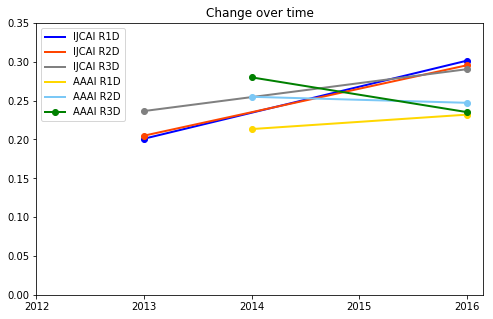

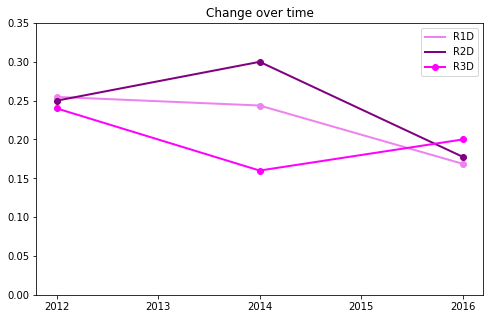

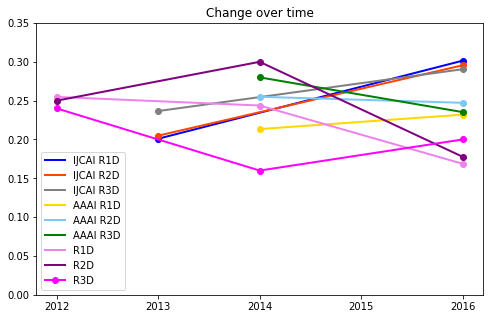

In [11]:
def create_timeline(RX_means):
    map_to_year = {'AAAI 14': 2014,
                   'AAAI 16': 2016,
                   'IJCAI 13': 2013,
                   'IJCAI 16': 2016}

    map_to_conf = {'AAAI 14': 'AAAI',
                   'AAAI 16': 'AAAI',
                   'IJCAI 13': 'IJCAI',
                   'IJCAI 16': 'IJCAI'}
    
    min_year = 2012 #min(map_to_year.values())
    max_year = max(map_to_year.values())
    
    RX_list = [mean.columns[0] for mean in RX_means]
    yeared_conferences = RX_means[0].index
    
    conferences = list(sorted({map_to_conf[name] for name in yeared_conferences}, reverse=True))
    headers = ["{conf} {RX}".format(conf=conf, RX=RX) for conf in conferences for RX in RX_list]
    
    index = list(range(min_year, max_year+1))
    data = [[float('nan') for i in headers] for year in index]
    df = pd.DataFrame(data, columns=headers, index=index)

    for RX_mean in RX_means:
        for IDX,row in RX_mean.iterrows():
            year = map_to_year[IDX]
            conf = map_to_conf[IDX]
            RX = row.index[0]
            mean = row[0]
            column_header = "{conf} {RX}".format(conf=conf, RX=RX)
            df[column_header][year] = mean

    return df

def plot(df, colors):
    for i,column in enumerate(df):
        markers = 'oooooo'
        mask = np.isfinite(df[column])
        df[column][mask].plot(legend=True,
                              marker=markers[i],
                              color=colors[i],
                              linewidth=2,
                              title="Change over time",
                              figsize=(8,5))

    plt.ylim(0.0, 0.35)
    plt.xticks([2012, 2013, 2014, 2015, 2016])
    #plt.show()
    #lt.clf()


df_aaai = create_timeline([R1_means_aaai, R2_means_aaai, R3_means_aaai])
display(df_aaai)

df_air2018 = pd.concat([R1_means_air2018, R2_means_air2018, R3_means_air2018],axis=1)
del df_air2018.index.name
display(df_air2018)


colors_A = ['blue', 'orangered', 'grey', 'gold', 'xkcd:lightblue', 'green']
colors_B = ['violet', 'purple', 'magenta']

plot(df_aaai, colors_A)
plt.show()
plt.clf()

plot(df_air2018, colors_B)
plt.show()
plt.clf()

plot(df_aaai, colors_A)
plot(df_air2018, colors_B)
plt.show()
plt.clf()



## Versions
Here's a generated output to keep track of software versions used to run this Jupyter notebook.

In [12]:
import IPython
import platform

print('Python version: {}'.format(platform.python_version()))
print('IPython version: {}'.format(IPython.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('numpy version: {}'.format(np.__version__))


Python version: 3.6.5
IPython version: 5.4.1
pandas version: 0.23.0
matplotlib version: 2.2.2
numpy version: 1.13.3
